 # Opis notatnika
 W tym notatniku tworzę system analityczno-raportowy, mający wspomagać przyszłe decyzje biznesowe. Dzięki przeprowadzonej wcześniej analizie eksploracyjnej danych, stworzę następujące wizualizacje danych:
 - Wyświetlenie TOP 10 tras samolotów pod względem najniższego odsetka opóźnień, w formie tabeli,
 - Wyświetlenie TOP 10 tras lotów dla minimalnej liczby lotów 10000, w formie tabeli,
 - Wyświetlenie porównania roku 2019 oraz 2020 w formie wykresu słupkowego:
     - miesiąc do miesiąca,
     - dzień tygodnia do dnia tygodnia,
 - Wyświetlenie danych dzień po dniu w formie szeregu czasowego.

Raport będzie się składać z trzech stron - `TOP report`, `Comparision` i `Day by day reliability`.

Pracując na podstawie wcześniej zdefiniowanych widoków, nie musimy się tutaj martwić o przetwarzanie oraz procesowanie danych. Co więcej, wszystkie niuanse techniczne w postaci liczby wierszy, wykonywanych złączeń, filtracji są przeniesione na bazę danych. Z technicznego punktu widzenia, pomiędzy serwisem a bazą danych dochodzi do przesyłania mniejszej ilości danych.


 Import wymaganych bibliotek

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import threading
import dash
from dash import Dash, dcc, html, dash_table, Input, Output, State, callback
from dash.dash_table import DataTable
from dash.dash_table.Format import Format, Scheme, Format, Scheme, Sign, Symbol, Group
from dash import Dash
from dash.dash_table import DataTable, FormatTemplate

 ## Konfiguracja połączenia

In [2]:
username = 'postgres'
password = '****'

host = 'localhost'
database = 'airlines'
port= '5432'

 Tworzę zmienne `url` oraz `engine`

In [3]:
url = URL.create(
    "postgresql",
    username=username,
    password=password,
    host=host,
    port=port,
    database=database,
)
engine = create_engine(url)

 # Stworzenie tabeli dla `TOP 10 routes`
 W tym miejscu przygotuję tabelkę oraz komponent, który zostanie następnie umieszczony w raporcie. Tabela będzie się składać z następujących kolumn:
 - Origin,
 - Destination,
 - Year,
 - Reliability,
 - Rank.

 Implementacja funkcji `read_sql_table`, która przyjmuje jeden argument:
 * `table_name` - nazwa ramki na bazie.

In [4]:
def read_sql_table(table_name):
    df = pd.read_sql(f"SELECT * FROM {table_name}", engine)
    return df

 Wczytuję tabelę z widoku `reporting.top_reliability_roads` używając funkcji `read_sql_table`

In [5]:
top_routes_df = read_sql_table('reporting.top_reliability_roads')

In [6]:
top_routes_df

,origin_airport_id,origin_airport_name,dest_airport_id,dest_airport_name,year,cnt,reliability,nb
0,13930,Chicago O'Hare International,12953,LaGuardia,2019,14219,0.274140,1
1,12953,LaGuardia,13930,Chicago O'Hare International,2019,14203,0.238964,2
2,12892,Los Angeles International,14771,San Francisco International,2019,14096,0.234109,3
3,14771,San Francisco International,12892,Los Angeles International,2019,14088,0.199886,4
4,12892,Los Angeles International,12478,John F. Kennedy International,2019,12797,0.194499,5
5,12892,Los Angeles International,12889,McCarran International,2019,11628,0.179309,6
6,12889,McCarran International,12892,Los Angeles International,2019,11616,0.175275,7
7,12478,John F. Kennedy International,12892,Los Angeles International,2019,12736,0.138505,8
8,13830,Kahului Airport,12173,Hollywood-Burbank Midpoint,2019,10718,0.064191,9
9,12173,Hollywood-Burbank Midpoint,13830,Kahului Airport,2019,10725,0.054452,10


 Aktualizuję format liczbowy dla kolumny `reliability`

In [7]:
top_routes_df['reliability'] = top_routes_df['reliability'].apply(lambda x: f"{x:.2%}")
top_routes_df

,origin_airport_id,origin_airport_name,dest_airport_id,dest_airport_name,year,cnt,reliability,nb
0,13930,Chicago O'Hare International,12953,LaGuardia,2019,14219,27.41%,1
1,12953,LaGuardia,13930,Chicago O'Hare International,2019,14203,23.90%,2
2,12892,Los Angeles International,14771,San Francisco International,2019,14096,23.41%,3
3,14771,San Francisco International,12892,Los Angeles International,2019,14088,19.99%,4
4,12892,Los Angeles International,12478,John F. Kennedy International,2019,12797,19.45%,5
5,12892,Los Angeles International,12889,McCarran International,2019,11628,17.93%,6
6,12889,McCarran International,12892,Los Angeles International,2019,11616,17.53%,7
7,12478,John F. Kennedy International,12892,Los Angeles International,2019,12736,13.85%,8
8,13830,Kahului Airport,12173,Hollywood-Burbank Midpoint,2019,10718,6.42%,9
9,12173,Hollywood-Burbank Midpoint,13830,Kahului Airport,2019,10725,5.45%,10


 Zmieniam nazwy kolumn

In [8]:
top_routes_df.rename(columns = {'origin_airport_name' : 'Origin',
                                'dest_airport_name' : 'Destination',
                                'year' : 'Year',
                                'reliability' : 'Reliability',
                                'nb' : 'Rank'}, inplace=True)

top_routes_df

,origin_airport_id,Origin,dest_airport_id,Destination,Year,cnt,Reliability,Rank
0,13930,Chicago O'Hare International,12953,LaGuardia,2019,14219,27.41%,1
1,12953,LaGuardia,13930,Chicago O'Hare International,2019,14203,23.90%,2
2,12892,Los Angeles International,14771,San Francisco International,2019,14096,23.41%,3
3,14771,San Francisco International,12892,Los Angeles International,2019,14088,19.99%,4
4,12892,Los Angeles International,12478,John F. Kennedy International,2019,12797,19.45%,5
5,12892,Los Angeles International,12889,McCarran International,2019,11628,17.93%,6
6,12889,McCarran International,12892,Los Angeles International,2019,11616,17.53%,7
7,12478,John F. Kennedy International,12892,Los Angeles International,2019,12736,13.85%,8
8,13830,Kahului Airport,12173,Hollywood-Burbank Midpoint,2019,10718,6.42%,9
9,12173,Hollywood-Burbank Midpoint,13830,Kahului Airport,2019,10725,5.45%,10


In [9]:
top_routes_df = top_routes_df[['Origin', 'Destination', 'Year', 'Reliability', 'Rank']]
top_routes_df

,Origin,Destination,Year,Reliability,Rank
0,Chicago O'Hare International,LaGuardia,2019,27.41%,1
1,LaGuardia,Chicago O'Hare International,2019,23.90%,2
2,Los Angeles International,San Francisco International,2019,23.41%,3
3,San Francisco International,Los Angeles International,2019,19.99%,4
4,Los Angeles International,John F. Kennedy International,2019,19.45%,5
5,Los Angeles International,McCarran International,2019,17.93%,6
6,McCarran International,Los Angeles International,2019,17.53%,7
7,John F. Kennedy International,Los Angeles International,2019,13.85%,8
8,Kahului Airport,Hollywood-Burbank Midpoint,2019,6.42%,9
9,Hollywood-Burbank Midpoint,Kahului Airport,2019,5.45%,10


# Stworzenie tabeli dla `TOP 10 airports`

 Wczytuję tabelę z widoku `reporting.top_airports_by_departure` używając funkcji `read_sql_table`

In [10]:
top_airports_df = read_sql_table('reporting.top_airports_by_departure')

In [11]:
top_airports_df

,origin_airport_name,departures,arrivals,year,reliability,nb
0,Chicago O'Hare International,105437,121579,2019,0.233210,1
1,Stapleton International,64525,79166,2019,0.220287,2
2,Dallas Fort Worth Regional,39511,48326,2019,0.220065,3
3,San Francisco International,63459,77157,2019,0.217463,4
4,Logan International,55989,69216,2019,0.213578,5
5,LaGuardia,57708,70252,2019,0.211028,6
6,McCarran International,38456,47743,2019,0.198981,7
7,Los Angeles International,93702,115161,2019,0.191490,8
8,Atlanta Municipal,123162,150816,2019,0.186056,9
9,Seattle International,50465,60815,2019,0.177291,10


 Aktualizuję format liczbowy dla kolumny `reliability`

In [12]:
top_airports_df['reliability'] = top_airports_df['reliability'].apply(lambda x: f"{x:.2%}")
top_airports_df

,origin_airport_name,departures,arrivals,year,reliability,nb
0,Chicago O'Hare International,105437,121579,2019,23.32%,1
1,Stapleton International,64525,79166,2019,22.03%,2
2,Dallas Fort Worth Regional,39511,48326,2019,22.01%,3
3,San Francisco International,63459,77157,2019,21.75%,4
4,Logan International,55989,69216,2019,21.36%,5
5,LaGuardia,57708,70252,2019,21.10%,6
6,McCarran International,38456,47743,2019,19.90%,7
7,Los Angeles International,93702,115161,2019,19.15%,8
8,Atlanta Municipal,123162,150816,2019,18.61%,9
9,Seattle International,50465,60815,2019,17.73%,10


Zmieniam nazwy kolumn

In [13]:
top_airports_df.rename(columns = {'origin_airport_name' : 'Origin',
                                'departures' : 'Departures',
                                'arrivals' : 'Arrivals',
                                'year' : 'Year',
                                'reliability' : 'Reliability',
                                'nb' : 'Rank'}, inplace=True)

top_airports_df

,Origin,Departures,Arrivals,Year,Reliability,Rank
0,Chicago O'Hare International,105437,121579,2019,23.32%,1
1,Stapleton International,64525,79166,2019,22.03%,2
2,Dallas Fort Worth Regional,39511,48326,2019,22.01%,3
3,San Francisco International,63459,77157,2019,21.75%,4
4,Logan International,55989,69216,2019,21.36%,5
5,LaGuardia,57708,70252,2019,21.10%,6
6,McCarran International,38456,47743,2019,19.90%,7
7,Los Angeles International,93702,115161,2019,19.15%,8
8,Atlanta Municipal,123162,150816,2019,18.61%,9
9,Seattle International,50465,60815,2019,17.73%,10


 # Porównanie rok do roku (YoY) 2019 vs. 2020

 Wczytuję tabelę z widoku `reporting.year_to_year_comparision` dane do ramki `yoy_comparision_df`

In [14]:
yoy_comparision_df = read_sql_table('reporting.year_to_year_comparision')
yoy_comparision_df

,year,month,flights_amount,reliability
0,2019,1,86826,0.180787
1,2019,2,79514,0.218565
2,2019,3,91789,0.176056
3,2019,4,89505,0.182794
4,2019,5,94256,0.204687
5,2019,6,92823,0.247622
6,2019,7,95971,0.216690
7,2019,8,98725,0.210322
8,2019,9,90789,0.147661
9,2019,10,95901,0.163460


 Przekształcam tabelkę do formy tabeli przestawnej

In [15]:
yoy_comparision_to_plot_df = pd.pivot(data=yoy_comparision_df,
                                            index=['month'],
                                            columns=['year'],
                                            values=['reliability'],
                                            )
yoy_comparision_to_plot_df

reliability          
year         2019      2020
month                      
1        0.180787  0.125757
2        0.218565  0.134419
3        0.176056  0.092797
4        0.182794       NaN
5        0.204687       NaN
6        0.247622       NaN
7        0.216690       NaN
8        0.210322       NaN
9        0.147661       NaN
10       0.163460       NaN
11       0.139236       NaN
12       0.207854       NaN

In [16]:
yoy_comparision_to_plot_df.columns

MultiIndex([('reliability', 2019),
            ('reliability', 2020)],
           names=[None, 'year'])

In [17]:
columns = [yoy_comparision_to_plot_df.columns[0][1], yoy_comparision_to_plot_df.columns[1][1]]
columns

[2019, 2020]

In [18]:
yoy_comparision_to_plot_df.values

array([[0.18078686, 0.12575747],
       [0.21856528, 0.13441886],
       [0.17605595, 0.09279704],
       [0.18279426,        nan],
       [0.20468723,        nan],
       [0.24762182,        nan],
       [0.21669046,        nan],
       [0.2103216 ,        nan],
       [0.14766106,        nan],
       [0.16346024,        nan],
       [0.13923567,        nan],
       [0.20785438,        nan]])

In [19]:
max_value = np.nanmax(yoy_comparision_to_plot_df.values)
max_value

0.24762181786841622

In [20]:
yoy_comparision_to_plot_df.values[0][0]

0.1807868610784788

In [21]:
yoy_comparision_to_plot_df.index

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='month')

<Axes: xlabel='month'>

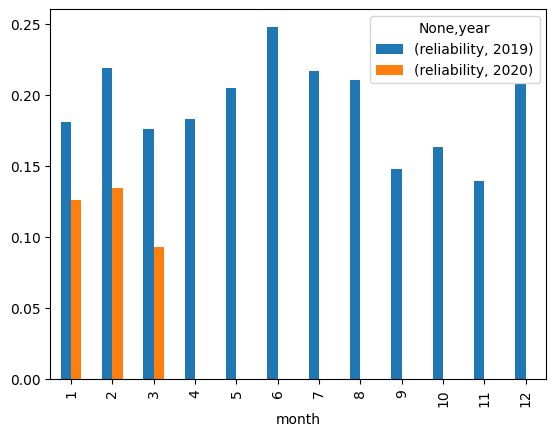

In [22]:
yoy_comparision_to_plot_df.plot(kind='bar')

 Tworzę wykres słupkowy, zapisuję go do zmiennej `yoy_comparision_fig`.

In [23]:
yoy_comparision_fig = px.bar(   yoy_comparision_to_plot_df, 
                                x=yoy_comparision_to_plot_df.index,
                                y=[[yoy_comparision_to_plot_df.values[i][0] for i in range(0,12)], [yoy_comparision_to_plot_df.values[i][1] for i in range(0,12)]],
                                barmode='group',
                                height=600, 
                                width=1400,
                                title='<b>Comparison of Reliability between 2019 and 2020 by Month',
                                text_auto=True,
                                color_discrete_map={'wide_variable_0': '#5995ED', 'wide_variable_1': '#FF9F1C'},

                                )

month = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December']

yoy_comparision_fig.update_layout(  xaxis = dict(   
                                                    title='<b>Month',
                                                    titlefont=dict(size=14),
                                                    tickvals = [i for i in range(1,13)],
                                                    ticktext = month,
                                                    tickson="boundaries",
                                                    ticks="outside", 
                                                    ticklen=2,
                                                    tickwidth=80,
                                                    tickfont=dict(size=14),
                                                                    ),
                                    yaxis = dict(
                                                    title='<br><b>Percentage of delays (%)',
                                                    titlefont=dict(size=14),
                                                    range=[0, max_value+0.05], 
                                                    tickformat=".0%",
                                                    tickson="boundaries",
                                                    ticks="outside",
                                                    ticklen=15,
                                                    tickwidth=1,
                                                    tickcolor='white',
                                                    tickfont=dict(size=14),
                                                    ),
                                    legend_title="Year",
                                    titlefont=dict(size=24),
                                    plot_bgcolor="#E4EEF1"
                                    )
yoy_comparision_fig.update_traces(hovertemplate="Month: <b>%{x}</b> <br>Percentage of delay (%): <b>%{y}</b> <br>Year: <b>%{fullData.name}</b>", 
                                  texttemplate='<span style="font-size: 13px;"><b>%{y:.2%}</b></span>',
                                  )

yoy_comparision_fig.for_each_trace(lambda t: t.update(name="2019" if t.name == "wide_variable_0" else "2020"))

yoy_comparision_fig.show()

c:\Users\ktkat\pyver\py383\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


 # Porównanie dzień tygodnia do dnia tygodnia (WKoWK) 2019 vs. 2020

 Wczytuję tabelę z widoku `reporting.day_to_day_comparision` dane do ramki `day_to_day_comparision_df`

In [24]:
day_to_day_comparision_df = read_sql_table('reporting.day_to_day_comparision')
day_to_day_comparision_df

,year,day_of_week,flights_amount,reliability
0,2019,1,164325,0.201266
1,2019,2,162265,0.174751
2,2019,3,160092,0.182782
3,2019,4,162989,0.212168
4,2019,5,165283,0.203227
5,2019,6,127682,0.167831
6,2019,7,153106,0.192409
7,2020,1,37713,0.099250
8,2020,2,36396,0.088389
9,2020,3,37532,0.096504


 Przekształcam tabelkę do formy tabeli przestawnej

In [25]:
day_to_day_comparision_to_plot_df = pd.pivot(   data=day_to_day_comparision_df,
                                                index=['day_of_week'],
                                                columns=['year'],
                                                values=['reliability'],
                                                )
day_to_day_comparision_to_plot_df

reliability          
year               2019      2020
day_of_week                      
1              0.201266  0.099250
2              0.174751  0.088389
3              0.182782  0.096504
4              0.212168  0.161884
5              0.203227  0.150788
6              0.167831  0.117297
7              0.192409  0.113561

In [26]:
day_to_day_comparision_to_plot_df.columns

MultiIndex([('reliability', 2019),
            ('reliability', 2020)],
           names=[None, 'year'])

In [27]:
columns = [day_to_day_comparision_to_plot_df.columns[0][1], day_to_day_comparision_to_plot_df.columns[1][1]]
columns

[2019, 2020]

In [28]:
day_to_day_comparision_to_plot_df.values

array([[0.20126578, 0.0992496 ],
       [0.17475118, 0.08838883],
       [0.1827824 , 0.09650432],
       [0.21216769, 0.16188397],
       [0.20322719, 0.15078803],
       [0.16783102, 0.1172972 ],
       [0.19240918, 0.11356138]])

In [29]:
max_value = np.nanmax(day_to_day_comparision_to_plot_df.values)
max_value

0.21216769229825325

In [30]:
day_to_day_comparision_to_plot_df.index

Index([1, 2, 3, 4, 5, 6, 7], dtype='int64', name='day_of_week')

<Axes: xlabel='day_of_week'>

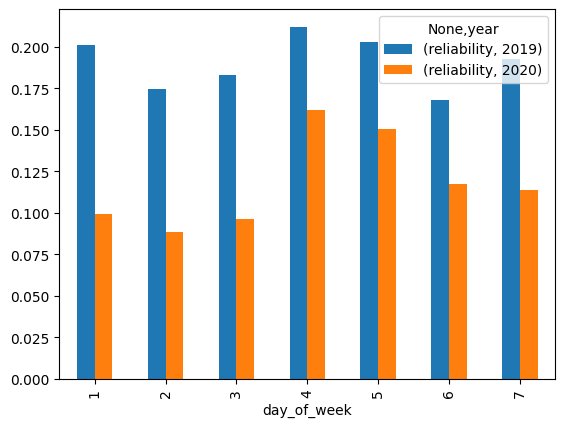

In [31]:
day_to_day_comparision_to_plot_df.plot(kind='bar')

 Tworzę wykres słupkowy, zapisuję go do zmiennej `day_to_day_comparision_fig`.

In [32]:
day_to_day_comparision_fig = px.bar(    day_to_day_comparision_to_plot_df, 
                                        x=day_to_day_comparision_to_plot_df.index,
                                        y=[[day_to_day_comparision_to_plot_df.values[i][0] for i in range(0,7)], [day_to_day_comparision_to_plot_df.values[i][1] for i in range(0,7)]],
                                        barmode='group',
                                        height=600, 
                                        width=1400,
                                        title='<b>Comparison of Reliability between 2019 and 2020 by Day of week',
                                        text_auto=True,
                                        color_discrete_map={'wide_variable_0': '#5995ED', 'wide_variable_1': '#FF9F1C'},
                                        )

day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_to_day_comparision_fig.update_layout(xaxis = dict(  
                                                        title='<b>Day of week',
                                                        titlefont=dict(size=14),
                                                        tickvals = [i for i in range(1,8)],
                                                        ticktext = day_of_week,
                                                        tickson="boundaries",
                                                        ticks="outside",
                                                        ticklen=2,
                                                        tickwidth=135,
                                                        tickfont=dict(size=14),
                                                        ),
                                         yaxis = dict(
                                                        title='<br><b>Percentage of delays (%)',
                                                        titlefont=dict(size=14),
                                                        range=[0, max_value+0.05], 
                                                        tickformat=".0%",
                                                        tickson="boundaries",
                                                        ticks="outside",
                                                        ticklen=15,  
                                                        tickwidth=1,
                                                        tickcolor='white',
                                                        tickfont=dict(size=14),
                                                        ),
                                         legend_title="Year",
                                         titlefont=dict(size=24),
                                         plot_bgcolor="#E4EEF1"
                                        )
day_to_day_comparision_fig.update_traces(hovertemplate="Day of week: <b>%{x}</b> <br>Percentage of delay (%): <b>%{y}</b> <br>Year: <b>%{fullData.name}</b>",
                                        texttemplate='<span style="font-size: 13px;"><b>%{y:.2%}</b></span>',
                                        )

day_to_day_comparision_fig.for_each_trace(lambda t: t.update(name="2019" if t.name == "wide_variable_0" else "2020"))

day_to_day_comparision_fig.show()

c:\Users\ktkat\pyver\py383\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



 # Stworzenie szeregu czasowego
 Tworzę wykres w formie szeregu czasowego, który zostanie umieszcony w raporcie. Wykres będzie przedstawiać dane w formie szeregu czasowego (dzień po dniu) dla lat 2019 oraz 2020. Dla możliwości identyfikacji poszczególnych lat, nadam inny koloru dla roku 2019 oraz 2020.

 Wczytuję tabelę z widoku `reporting.day_by_day_reliability` dane do ramki `day_by_day_reliability_df`.

In [33]:
day_by_day_reliability_df = read_sql_table('reporting.day_by_day_reliability')
day_by_day_reliability_df.head()

,date,reliability
0,2019-01-01,0.186556
1,2019-01-02,0.215106
2,2019-01-03,0.145952
3,2019-01-04,0.114245
4,2019-01-05,0.188235


In [34]:
day_by_day_reliability_df['date'] = pd.to_datetime(day_by_day_reliability_df['date'])

 Tworzę wykres liniowy na podstawie pobranych danych. Wynik zapisuję do zmiennej `day_by_day_reliability_fig`.

In [35]:
first_day_of_month_list = pd.date_range(start=day_by_day_reliability_df['date'].min(), 
                                        end=day_by_day_reliability_df['date'].max() + pd.DateOffset(months=1), # równie dobrze może być + relativedelta(months =+ 1),
                                        freq='MS')
first_day_of_month_list

DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [36]:
[i for i in range(1, len(first_day_of_month_list) + 1)]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [37]:
day_by_day_reliability_fig = px.line(  data_frame=day_by_day_reliability_df,
                                        x='date',
                                        y='reliability',
                                        color=day_by_day_reliability_df['date'].dt.year,
                                        markers=True,
                                        height=600, 
                                        width=1500,
                                        title='<b>Percentage of delays in 2019 and 2020 by Day',
                                        color_discrete_sequence=['#5995ED', '#FF9F1C'],
                                        )

day_by_day_reliability_fig.update_layout(xaxis = dict(
                                                        title='<b>Day by day',
                                                        titlefont=dict(size=14),
                                                        tickmode='array',
                                                        tickvals = [date for date in first_day_of_month_list],
                                                        ticktext = first_day_of_month_list.strftime("%b<br>%Y"),
                                                        tickson="boundaries",
                                                        ticks="outside",
                                                        ticklen=15,
                                                        tickwidth=1,
                                                        tickcolor='gray', 
                                                        ),
                                         yaxis = dict(
                                                        title='<br><b>Percentage of delays (%)',
                                                        titlefont=dict(size=14),
                                                        range=[0, day_by_day_reliability_df['reliability'].max()+0.05], 
                                                        tickformat=".0%",
                                                        tickson="boundaries",
                                                        ticks="outside",
                                                        ticklen=15,
                                                        tickwidth=1,
                                                        tickcolor='white',
                                                        ),
                                         hovermode="x unified", # 'x' / 'closest' / 'x unified'
                                         hoverlabel_align = 'auto',
                                         legend_title="Year",
                                         titlefont=dict(size=24),
                                         plot_bgcolor="#E4EEF1"
                                        )

day_by_day_reliability_fig.update_traces(mode="lines", hovertemplate="Date: <b>%{x}</b> <br>Percentage of delays (%): <b>%{y:.2%}</b>")

day_by_day_reliability_fig.update_xaxes(range=[first_day_of_month_list[0], first_day_of_month_list[-1]])

day_by_day_reliability_fig.show()

c:\Users\ktkat\pyver\py383\Lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



 # Stworzenie layoutów poszczególnych stron

 ## Stworzenie layout dla widoku `TOP 10 routes` i dla widoku `TOP 10 airports`

In [38]:
top_routes_airports_layout = html.Div([  html.H1("TOP 10 reliability routes and airports in 2019 and 2020", style={'fontFamily': 'verdana', 'color': '#4444'}),
                                                html.Div([
                                                            html.Div([
                                                                        html.H3("TOP 10 flight routes by highest delay percentage", style={'fontFamily': 'verdana', 'color': '#4444'}),
                                                                        dash_table.DataTable(
                                                                                            id='table-routes',
                                                                                            columns=[
                                                                                                {"name": ["Origin"], "id": "Origin", "type": "text"},
                                                                                                {"name": ["Destination"], "id": "Destination", "type": "text"},
                                                                                                {"name": ["Year"], "id": "Year", "type": "numeric"},
                                                                                                {"name": ["Reliability"], "id": "Reliability", "type": "numeric"},
                                                                                                {"name":["Rank"], "id":"Rank", "type": "numeric"},],
                                                                                            data=top_routes_df.to_dict('records'),
                                                                                            style_table = {'width':500,'height':500},
                                                                                            style_data_conditional=[
                                                                                            {
                                                                                                'if': {'row_index': 'odd'},
                                                                                                'backgroundColor': 'rgb(200, 220, 240)',
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_type': 'text'},
                                                                                                    'textAlign': 'left',
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_type': 'numeric'},
                                                                                                    'textAlign': 'center'
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_id': 'Year'},
                                                                                                'minWidth': '60px'
                                                                                            },
                                                                                            ],
                                                                                            style_header={
                                                                                            'backgroundColor': '#5995ED',
                                                                                            'fontWeight': 'bold',
                                                                                            'textAlign': 'center'
                                                                                            },
                                                                                            style_cell={'font_family': 'verdana', 'font_size': '14px',
                                                                                                        }
                                                                                            ),
                                                                    ], style={'display':'inline-block', 'width':'50%', 'height':500}),
                                                            html.Div([
                                                                        html.H3("TOP 10 airports with the highest number of departures by delay percentage", 
                                                                                style={'fontFamily': 'verdana', 'color': '#4444', 'width':'70%'}), 
                                                                        dash_table.DataTable(
                                                                                            id='table-airports',
                                                                                            columns=[
                                                                                                {"name": ["Origin"], "id": "Origin", "type": "text"},
                                                                                                {"name": ["Departures"], "id": "Departures", "type": "numeric", "format": Format().group(True)},
                                                                                                {"name": ["Arrivals"], "id": "Arrivals", "type": "numeric", "format": Format().group(True)},
                                                                                                {"name": ["Year"], "id": "Year", "type": "numeric"},
                                                                                                {"name": ["Reliability"], "id": "Reliability", "type": "numeric"},
                                                                                                {"name":["Rank"], "id":"Rank", "type": "numeric"},],
                                                                                            data=top_airports_df.to_dict('records'),
                                                                                            style_table = {'width':500,'height':500},
                                                                                            style_data_conditional=[
                                                                                            {
                                                                                                'if': {'row_index': 'odd'},
                                                                                                'backgroundColor': 'rgb(200, 220, 240)',
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_type': 'text'},
                                                                                                    'textAlign': 'left',
                                                                                            },
                                                                                             {
                                                                                                'if': {'column_id': 'Departures'},
                                                                                                'textAlign': 'right',
                                                                                                'minWidth': '80px'
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_id': 'Arrivals'},
                                                                                                'textAlign': 'right',
                                                                                                'minWidth': '80px'
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_id': 'Year'},
                                                                                                'textAlign': 'center',
                                                                                                'minWidth': '60px'
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_id': 'Reliability'},
                                                                                                'textAlign': 'center',
                                                                                            },
                                                                                            {
                                                                                                'if': {'column_id': 'Rank'},
                                                                                                'textAlign': 'center',
                                                                                            },
                                                                                            {
                                                                                                'if': {
                                                                                                    'filter_query': '{{Departures}} = {}'.format(top_airports_df['Departures'].max()),
                                                                                                    'column_id': 'Departures'
                                                                                                },
                                                                                                'backgroundColor': '#CD5D67',
                                                                                            },
                                                                                            {
                                                                                                'if': {
                                                                                                    'filter_query': '{{Departures}} = {}'.format(top_airports_df['Departures'].min()),
                                                                                                    'column_id': 'Departures'
                                                                                                },
                                                                                                'backgroundColor': '#ACF39D',
                                                                                            }
                                                                                            ],
                                                                                            style_header={
                                                                                            'backgroundColor': '#5995ED',
                                                                                            'fontWeight': 'bold',
                                                                                            'textAlign': 'center'
                                                                                            },
                                                                                            style_cell={'font_family': 'verdana', 'font_size': '14px',
                                                                                                        }
                                                                                            )
                                                                            ], style={'display':'inline-block', 'width':'50%', 'height':500, 'align':'center'})
                                                            ], style={'display':'inline-block', 'width':'85%', 'height':500, 'align':'center'})
                                                ])

 ## Stworzenie layout dla widoku `Comparision`

In [39]:
comparision_layout = html.Div([  html.H1("Comparison of Reliability between 2019 and 2020", style={'fontFamily': 'verdana', 'color': '#4444'}),
                                        html.Div([  
                                                    dcc.Dropdown(
                                                                id='dropdown',
                                                                clearable=False,
                                                                value='Month',
                                                                options=['Month', 'Day of Week'],
                                                                style={'fontFamily': 'verdana',
                                                                       'width':'30%',
                                                                       'font-size': '14px',
                                                                       'border-radius': '10px',
                                                                        }
                                                    ),
                                                    html.Br(style={"line-height": "15"}),
                                                    dcc.Graph(
                                                                id='graph1-2',
                                                                style={'display':'inline-block',}
                                                                ),
                                                    ])
                                        ])

 ## Stworzenie layout dla widoku `Day by day`.

In [40]:
day_by_day_layout = html.Div([  html.H1("Day by day Reliability in 2019 and 2020", style={'fontFamily': 'verdana', 'color': '#4444'}),
                                       html.Div([
                                                    dcc.Graph(
                                                                id='graph3',
                                                                figure=day_by_day_reliability_fig
                                                                ),
                                                    ])
                                        ])

 # Konfigurowanie aplikacji
 Posiadam już wszystkie niezbędne komponenty do stworzenia oraz uruchomienia aplikacji. Potrzebuję skonfigurować ją tak, aby obsługiwała więcej niż jedną stronę.

 Chcę, aby możliwe było poruszanie się pomiędzy poniższymi stronami:
 - `TOP report` - strona domyślna,
 - `Comparision` - strona dostępna pod adresem: `comparision_reporting`,
 - `Day by day reporting` - strona dostępna pod adresem: `day_by_day_reporting`


 Przygotowuję layout aplikacji

In [41]:
app = Dash()

button_style = {
                'background-color': '#5995ED',
                'border': 'none', 
                'color': 'white',
                'padding': '15px 32px',
                'text-align': 'center',
                'text-decoration': 'none',
                'display': 'inline-block',
                'fontFamily': 'verdana',
                'font-size': '18px',
                'margin': '4px 4px',
                'border-radius': '10px',
                }


app.layout = html.Div([
                        dcc.Location(id='url', refresh=False),
                        dcc.Link('Top 10', href='/', style=button_style),
                        dcc.Link('YoY & WKoWK', href='/2', style=button_style),
                        dcc.Link('Day by day Reliability', href='/3', style=button_style),
                        html.Div(id='page-content')
])

 Tworzę procedurę odpowiadającą za nawigację pomiędzy poszczególnymi stronami

In [42]:
@app.callback(
    Output('page-content', 'children'),
    [Input('url', 'pathname')])
def display_page_content(pathname):
    if pathname == '/':
        return top_routes_airports_layout
    elif pathname == '/2':
        return comparision_layout
    elif pathname == '/3':
        return day_by_day_layout
    else:
        return html.Div("Page does not exist")
    
@app.callback(
    Output('graph1-2', 'figure'),
    [Input('dropdown', 'value')])
def choose_graph(value):
    if value == 'Month':
        return yoy_comparision_fig
    elif value == 'Day of Week':
        return day_to_day_comparision_fig

 Uruchamiam aplikację

In [43]:
thread = threading.Thread(target=app.run_server(port=8050, height='600'))
thread.start()

 # Podsumowanie
 W tym notatniku stworzyliśmy zgodnie z wymaganiami raport do dyspozycji osób decyzyjnych. Kod źródłowy może w tym momencie zostać przekazany dalej, do działu IT, który następnie wdroży rozwiązanie na serwer dostępny dla każdej zainteresowanej osoby. W praktyce oznacza to koniec naszej pracy nad tym zadaniem. Choć warto dodać, że często po udostępnieniu raportu pojawiają się dodatkowe wymagania oraz komentarze ze względu na informacje, które są tam zawarte.

 W kolejnym notatniku podsumujemy sobie cały warsztat.